<a href="https://colab.research.google.com/github/aaryyya/MLDL_Assignments/blob/main/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import optuna
import warnings

warnings.filterwarnings("ignore")

# === Load datasets ===
df_num = pd.read_csv("preprocessed_dataset.csv")
df_train_img = pd.read_csv("extracted_features_train.csv")
df_test_img = pd.read_csv("extracted_features_test.csv")

label_col = 'trojan_type'
features_to_scale = [col for col in df_num.columns if col != label_col]

# === Validate dataset sizes ===
total_needed = len(df_train_img) + len(df_test_img)
if len(df_num) < total_needed:
    raise ValueError(f"preprocessed_dataset.csv must have at least {total_needed} rows.")

# === Split data ===
num_train = df_num.iloc[:len(df_train_img)].reset_index(drop=True)
num_test = df_num.iloc[len(df_train_img):len(df_train_img) + len(df_test_img)].reset_index(drop=True)

scaler = StandardScaler()
scaled_train = scaler.fit_transform(num_train[features_to_scale])
scaled_test = scaler.transform(num_test[features_to_scale])

scaled_train_df = pd.DataFrame(scaled_train, columns=features_to_scale)
scaled_test_df = pd.DataFrame(scaled_test, columns=features_to_scale)

df_train_img = df_train_img.select_dtypes(include=['number']).reset_index(drop=True)
df_test_img = df_test_img.select_dtypes(include=['number']).reset_index(drop=True)

X_train_full = pd.concat([df_train_img, scaled_train_df], axis=1)
X_test = pd.concat([df_test_img, scaled_test_df], axis=1)

le = LabelEncoder()
y_train_full = le.fit_transform(num_train[label_col])
y_test = le.transform(num_test[label_col])

# === Use validation split for tuning ===
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# === Optuna Objective ===
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# === Run Optuna Tuning (fast) ===
print("🔧 Running quick Optuna tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# === Train final model ===
print("✅ Best Params:", study.best_trial.params)
best_model = RandomForestClassifier(**study.best_trial.params)
best_model.fit(X_train_full, y_train_full)

# === Evaluate on test set ===
y_pred = best_model.predict(X_test)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred):.4f}")



# === SHAP Explanation ===
print("\n📈 Running SHAP analysis...")
explainer = shap.TreeExplainer(best_model.get_booster())


shap_values = explainer.shap_values(X_test)


# SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_xgb.png", bbox_inches='tight')
print("✅ SHAP summary saved as 'shap_summary_xgb.png'.")

# === CRL-like Causal Inference using DRLearner ===
print("\n🧠 Estimating causal effect of predicted classes using DRLearner...")

# Create outcome: 1 if model predicted correctly, else 0
y_true_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)
correctness = (y_true_decoded == y_pred_decoded).astype(int)

# Sample for fast demo
sample_n = 300
X_sample = X_test[:sample_n]
T_sample = y_pred[:sample_n]        # action = model's predicted class
Y_sample = correctness[:sample_n]   # outcome = whether prediction was correct

# Fit DRLearner
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(n_estimators=100, random_state=0),
    model_propensity=RandomForestClassifier(n_estimators=100, random_state=0),
    model_final=RandomForestRegressor()
)
dr_learner.fit(Y_sample, T_sample, X=X_sample)

# Estimate effect of assigning each class
unique_classes = np.unique(T_sample)
print("\n🔍 Estimated Causal Effects (Average treatment effect if predicted class was X):")
for c in unique_classes:
    effect = dr_learner.effect(X_sample, T0=c)
    print(f"  Class {le.inverse_transform([c])[0]}: Mean Causal Effect = {np.mean(effect):.4f}")


[I 2025-04-16 07:13:50,083] A new study created in memory with name: no-name-bc8961fd-6f46-43fd-b562-610e54b0153a


🔧 Running quick Optuna tuning...


[I 2025-04-16 07:14:04,114] Trial 0 finished with value: 0.8873994638069705 and parameters: {'n_estimators': 57, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.8873994638069705.
[I 2025-04-16 07:14:21,999] Trial 1 finished with value: 0.8840482573726541 and parameters: {'n_estimators': 94, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.8873994638069705.
[I 2025-04-16 07:14:24,465] Trial 2 finished with value: 0.8766756032171582 and parameters: {'n_estimators': 58, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8873994638069705.
[I 2025-04-16 07:14:28,006] Trial 3 finished with value: 0.8780160857908847 and parameters: {'n_estimators': 74, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8873994638069705.
[I 2

✅ Best Params: {'n_estimators': 110, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.61      0.49      0.54        41
           2       1.00      0.86      0.92        35
           3       1.00      0.33      0.50         6
           4       0.97      0.84      0.90        38
           5       0.74      0.53      0.62        32
           6       0.97      0.97      0.97        38
           7       0.91      0.97      0.94        32
           8       0.63      0.50      0.56        24
           9       0.52      0.38      0.44        37
          10       0.88      0.35      0.50        20
          11       0.92      1.00      0.95       626

    accuracy                           0.89       957
   macro avg       0.84      0.68      0.73       957
weighted avg       0.88      0.89     

NameError: name 'shap' is not defined

In [3]:
!pip install shap



📈 Running SHAP analysis...
✅ SHAP summary saved as 'shap_summary_rf.png'.


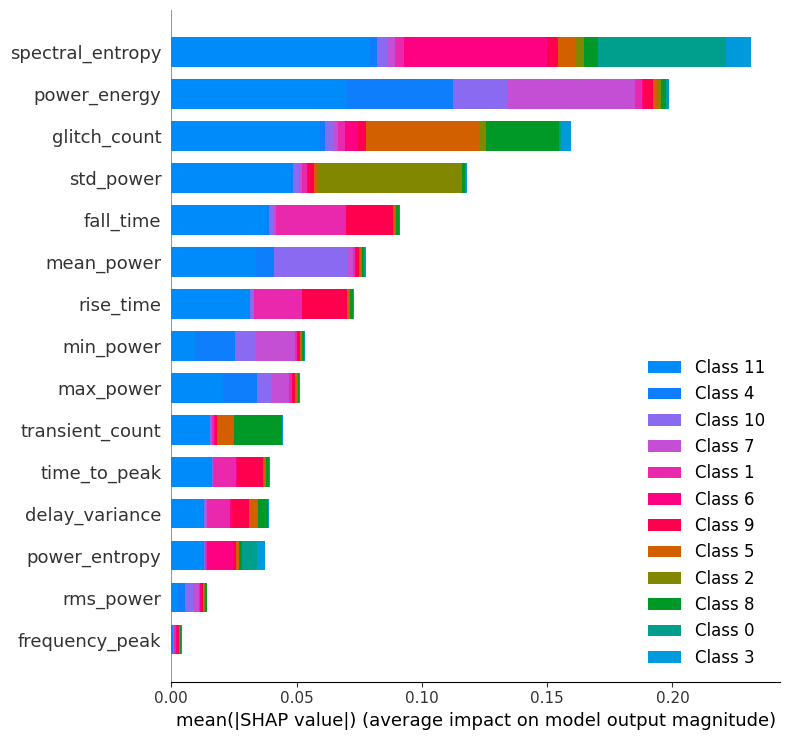

In [4]:
import shap
import matplotlib.pyplot as plt

# === SHAP Explanation ===
print("\n📈 Running SHAP analysis...")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_rf.png", bbox_inches='tight')
print("✅ SHAP summary saved as 'shap_summary_rf.png'.")


In [5]:
pip install econml

In [8]:
from collections import Counter

# Count predicted class frequencies
class_counts = Counter(T_sample)
top_k = 5  # you can change to 3 or more depending on balance
top_classes = [cls for cls, _ in class_counts.most_common(top_k)]

# Filter samples for only top_k classes
mask = np.isin(T_sample, top_classes)
X_filtered = X_sample[mask]
T_filtered = T_sample[mask]
Y_filtered = Y_sample[mask]

print(f"🧪 Using top-{top_k} most frequent predicted classes:", [le.inverse_transform([c])[0] for c in top_classes])

# Fit DRLearner
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(n_estimators=100, random_state=0),
    model_propensity=RandomForestClassifier(n_estimators=100, random_state=0),
    model_final=RandomForestRegressor()
)
dr_learner.fit(Y_filtered, T_filtered, X=X_filtered)

# Estimate causal effect for each of the top classes
ate_results = {}
print("\n🔍 Estimated Average Treatment Effects (ATE):")
for c in top_classes:
    effect = dr_learner.effect(X_filtered, T0=c)
    mean_effect = np.mean(effect)
    class_name = le.inverse_transform([c])[0]
    ate_results[class_name] = mean_effect
    print(f"  Class {class_name}: Mean Causal Effect = {mean_effect:.4f}")


🧪 Using top-5 most frequent predicted classes: [11, 4, 1, 2, 6]

🔍 Estimated Average Treatment Effects (ATE):
  Class 11: Mean Causal Effect = -0.0029
  Class 4: Mean Causal Effect = -0.0242
  Class 1: Mean Causal Effect = 0.0000
  Class 2: Mean Causal Effect = -0.0246
  Class 6: Mean Causal Effect = -0.0238


✅ Causal effect plot saved as 'causal_ate_barplot.png'.


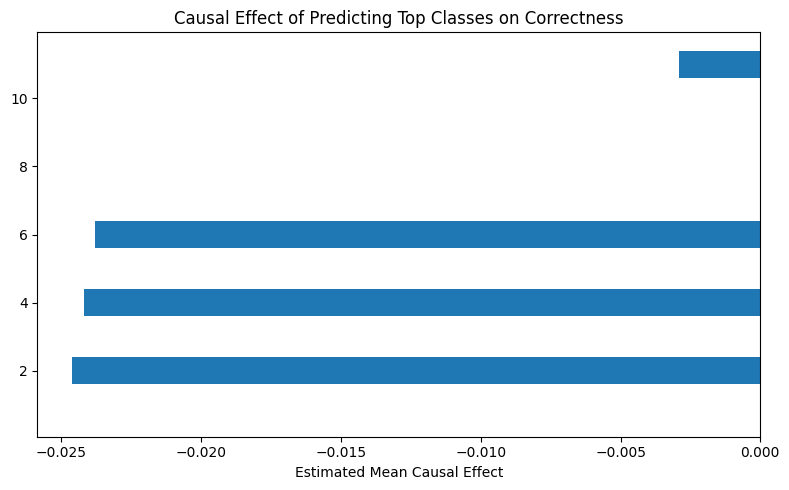

In [9]:
import matplotlib.pyplot as plt

# Plot ATEs
plt.figure(figsize=(8, 5))
plt.barh(list(ate_results.keys()), list(ate_results.values()))
plt.xlabel("Estimated Mean Causal Effect")
plt.title("Causal Effect of Predicting Top Classes on Correctness")
plt.tight_layout()
plt.savefig("causal_ate_barplot.png")
print("✅ Causal effect plot saved as 'causal_ate_barplot.png'.")
